# Disciple - 取引シミュレーション（Jupyter用）

In [1]:
import datetime
import os
import re

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata

from funcs.conv import conv_transaction_df2html
from funcs.setting import load_setting
from funcs.tide import get_date_dir_from_file
from funcs.tse import get_ticker_name_list
from modules.disciple import Disciple
from structs.res import AppRes

In [2]:
res = AppRes()

excel = "ticks_20260116.xlsx"
code = "7011"
# code = "7203"
# code = "8306"
dict_setting = load_setting(res, code)
THRESHOLD_SLOPE = dict_setting["THRESHOLD_SLOPE"]
TURBULENCE = dict_setting["TURBULENCE"]
date_str = get_date_dir_from_file(excel)
print(date_str)

app = Disciple(excel, code, dict_setting)
app.run()

2026/01/16
パラメータ
PERIOD_WARMUP : 180
PERIOD_MA_1 : 50
PERIOD_MA_2 : 500
PERIOD_SLOPE : 5
THRESHOLD_SLOPE : 0.05
PERIOD_RR : 30
TURBULENCE : 20.0
LOSSCUT_1 : -25
THRESHOLD_PM_MIN : 10.0
THRESHOLD_DDR_MIN : 0.7


In [3]:
# 取引明細
df_transaction = app.getTransaction()
df_transaction["累積損益"] = df_transaction["損益"].fillna(0).cumsum()
print("取引明細")
print(df_transaction)
print(df_transaction["注文日時"].dtype)
print(df_transaction["累積損益"].dtype)

list_html = conv_transaction_df2html(df_transaction)

output_dir = os.path.join("output", date_str)
os.makedirs(output_dir, exist_ok=True)
output = os.path.join(output_dir, f"{code}_transaction.html")
print(output)
with open(output, mode="w") as f:
    f.write("\n".join(list_html))

list_trans = df_transaction["注文日時"]
n_trade = len(df_transaction)
total = df_transaction["損益"].sum()
print(f"取引回数: {n_trade} 回 / 総収益: {total} 円/株")

取引明細
    注文番号                          注文日時 銘柄コード  売買    約定単価  約定数量      損益 備考  \
0      1 2026-01-16 09:09:04.760523081  8306  買建  2984.0   100     NaN      
1      2 2026-01-16 09:11:30.230745077  8306  売埋  2979.5   100  -450.0      
2      3 2026-01-16 09:11:31.221235991  8306  売建  2979.5   100     NaN      
3      4 2026-01-16 09:17:11.153475046  8306  買埋  2982.5   100  -300.0      
4      5 2026-01-16 09:17:12.158411980  8306  買建  2982.5   100     NaN      
5      6 2026-01-16 09:18:20.332238913  8306  売埋  2978.5   100  -400.0      
6      7 2026-01-16 09:18:21.338829994  8306  売建  2978.5   100     NaN      
7      8 2026-01-16 09:19:04.378906965  8306  買埋  2980.0   100  -150.0      
8      9 2026-01-16 09:21:51.799981117  8306  売建  2976.5   100     NaN      
9     10 2026-01-16 09:28:53.266946077  8306  買埋  2975.0   100   150.0      
10    11 2026-01-16 09:28:54.274476051  8306  売建  2975.0   100     NaN      
11    12 2026-01-16 09:29:41.348848104  8306  買埋  2978.5   100  -350.0 

In [4]:
# Matplotlib の共通設定
FONT_PATH = "fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

In [5]:
"""
累積損益のトレンドを作成するための準備
"""

# 元データ
ts = df_transaction["注文日時"]
pl = df_transaction["累積損益"]

# 日付（年月日）だけ取り出す
date = ts.iloc[0].normalize()

# 追加する先頭と末尾の行
start_row = pd.DataFrame(
    {
        "注文日時": [date + pd.Timedelta(hours=9)],
        "累積損益": [0.0],
    }
)

end_row = pd.DataFrame(
    {
        "注文日時": [date + pd.Timedelta(hours=15, minutes=30)],
        "累積損益": [pl.iloc[-1]],
    }
)

# トレンド用 DataFrame を作成
trend_df = pd.concat(
    [start_row, df_transaction[["注文日時", "累積損益"]], end_row], ignore_index=True
)

# 注文日時を index にした Series を作成
trend_series = trend_df.set_index("注文日時")["累積損益"]
trend_series

注文日時
2026-01-16 09:00:00.000000000       0.0
2026-01-16 09:09:04.760523081       0.0
2026-01-16 09:11:30.230745077    -450.0
2026-01-16 09:11:31.221235991    -450.0
2026-01-16 09:17:11.153475046    -750.0
2026-01-16 09:17:12.158411980    -750.0
2026-01-16 09:18:20.332238913   -1150.0
2026-01-16 09:18:21.338829994   -1150.0
2026-01-16 09:19:04.378906965   -1300.0
2026-01-16 09:21:51.799981117   -1300.0
2026-01-16 09:28:53.266946077   -1150.0
2026-01-16 09:28:54.274476051   -1150.0
2026-01-16 09:29:41.348848104   -1500.0
2026-01-16 09:29:42.357418060   -1500.0
2026-01-16 09:31:49.839376926   -2000.0
2026-01-16 09:31:50.829271078   -2000.0
2026-01-16 09:32:43.037406921   -2350.0
2026-01-16 09:32:44.042320013   -2350.0
2026-01-16 09:44:06.895347118   -2250.0
2026-01-16 09:44:07.914621115   -2250.0
2026-01-16 09:45:08.092000961   -2900.0
2026-01-16 09:45:09.081434011   -2900.0
2026-01-16 09:45:56.229527950   -3450.0
2026-01-16 09:45:57.230870962   -3450.0
2026-01-16 09:53:42.551194906   -27

output/2026/01/16/8306_trend_profit.png


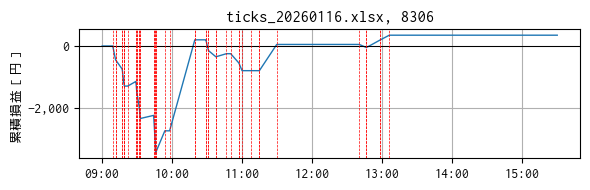

In [6]:
# 累積損益トレンド
fig, ax = plt.subplots(figsize=(6, 2))

ax.set_title(f"{excel}, {code}")
ax.plot(trend_series, linewidth=1)
ax.axhline(y=0, color="black", linewidth=0.75)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.set_ylabel("累積損益［円］")
for t in list_trans:
    ax.axvline(x=t, color="red", linestyle="dashed", linewidth=0.5)
ax.grid()

plt.tight_layout()
output_dir = os.path.join("output", date_str)
os.makedirs(output_dir, exist_ok=True)
output = os.path.join(output_dir, f"{code}_trend_profit.png")
print(output)
plt.savefig(output)
plt.show()

In [7]:
# テクニカル指標
print("テクニカル指標")
df_tech = app.getTechnicals()
print(df_tech)

テクニカル指標
                               ts   price          ma1          ma2    slope1  \
2026-01-16 09:00:04  1.768522e+09  2980.0  2980.000000  2980.000000  0.000000   
2026-01-16 09:00:05  1.768522e+09  2980.0  2980.000000  2980.000000  0.000000   
2026-01-16 09:00:06  1.768522e+09  2967.5  2975.833333  2975.833333  2.500000   
2026-01-16 09:00:07  1.768522e+09  2967.5  2973.750000  2973.750000  2.380952   
2026-01-16 09:00:08  1.768522e+09  2967.0  2972.400000  2972.400000  2.047222   
...                           ...     ...          ...          ...       ...   
2026-01-16 15:24:45  1.768545e+09  2997.5  2997.190000  2994.702000  0.012667   
2026-01-16 15:24:46  1.768545e+09  2997.5  2997.200000  2994.714000  0.013667   
2026-01-16 15:24:47  1.768545e+09  2997.5  2997.220000  2994.725000  0.014667   
2026-01-16 15:24:48  1.768545e+09  2997.5  2997.240000  2994.736000  0.016333   
2026-01-16 15:24:49  1.768545e+09  2997.5  2997.250000  2994.747000  0.015333   

                   

In [8]:
df_tech["slope1"].describe()

count    19427.000000
mean         0.029381
std          0.046106
min          0.000000
25%          0.010000
50%          0.020000
75%          0.038000
max          2.500000
Name: slope1, dtype: float64

output/2026/01/16/8306_trend_technical.png


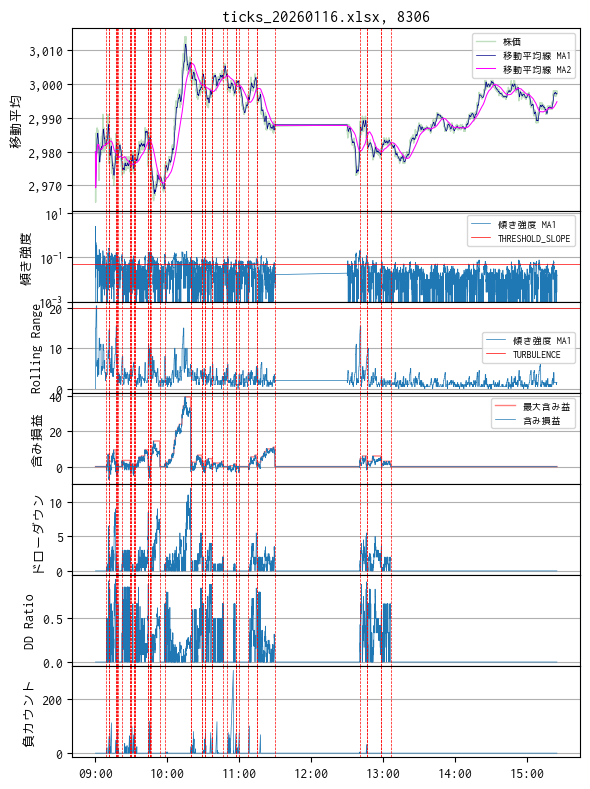

In [9]:
fig = plt.figure(figsize=(6, 8))
n = 7
ax = dict()
gs = fig.add_gridspec(
    n, 1, wspace=0.0, hspace=0.0, height_ratios=[2 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis
    ax[i].grid(axis="y")

ax[0].set_title(f"{excel}, {code}")
ax[0].plot(df_tech["price"], linewidth=1, color="green", alpha=0.25, label="株価")
ax[0].plot(df_tech["ma1"], linewidth=0.5, color="darkblue", label="移動平均線 MA1")
ax[0].plot(df_tech["ma2"], linewidth=0.75, color="magenta", label="移動平均線 MA2")
ax[0].set_ylabel("移動平均")
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax[0].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax[0].legend(fontsize=7)

ax[1].plot(df_tech["slope1"], linewidth=0.5, label="傾き強度 MA1")
ax[1].axhline(y=THRESHOLD_SLOPE, color="red", linewidth=0.5, label="THRESHOLD_SLOPE")
ax[1].set_yscale("log")
ax[1].set_ylabel("傾き強度")
ax[1].legend(fontsize=7)
_, y_high = ax[1].get_ylim()
ax[1].set_ylim(0.001, y_high)

ax[2].plot(df_tech["rr"], linewidth=0.5, label="傾き強度 MA1")
ax[2].axhline(y=TURBULENCE, color="red", linewidth=0.5, label="TURBULENCE")
ax[2].set_ylabel("Rolling Range")
ax[2].legend(fontsize=7)

ax[3].plot(
    df_tech["profit_max"], linewidth=1, color="red", alpha=0.5, label="最大含み益"
)
ax[3].plot(df_tech["profit"], linewidth=0.5, color="C0", label="含み損益")
ax[3].set_ylabel("含み損益")
ax[3].legend(fontsize=7)

ax[4].plot(df_tech["drawdown"], linewidth=0.5)
ax[4].set_ylabel("ドローダウン")

ax[5].plot(df_tech["dd_ratio"], linewidth=0.5)
ax[5].set_ylabel("DD Ratio")

ax[6].plot(df_tech["n_minus"], linewidth=0.5)
ax[6].set_ylabel("負カウント")

for i in range(n):
    for t in list_trans:
        ax[i].axvline(x=t, color="red", linestyle="dashed", linewidth=0.5)

plt.tight_layout()
output_dir = os.path.join("output", date_str)
os.makedirs(output_dir, exist_ok=True)
output = os.path.join(output_dir, f"{code}_trend_technical.png")
print(output)
plt.savefig(output)
plt.show()

output/2026/01/16/8306_hist_slope.png


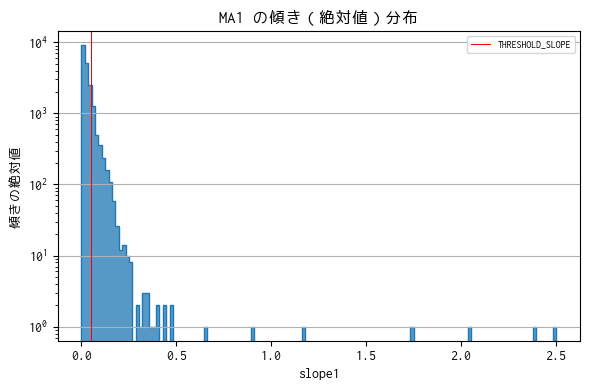

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("MA1 の傾き（絶対値）分布")
sns.histplot(data=df_tech, x="slope1", bins="sqrt", element="step")
ax.axvline(x=THRESHOLD_SLOPE, color="red", linewidth=0.75, label="THRESHOLD_SLOPE")
ax.set_yscale("log")
ax.set_ylabel("傾きの絶対値")
ax.grid(axis="y")
ax.legend(fontsize=7)

plt.tight_layout()
output_dir = os.path.join("output", date_str)
os.makedirs(output_dir, exist_ok=True)
output = os.path.join(output_dir, f"{code}_hist_slope.png")
print(output)
plt.savefig(output)
plt.show()

output/2026/01/16/8306_hist_rr.png


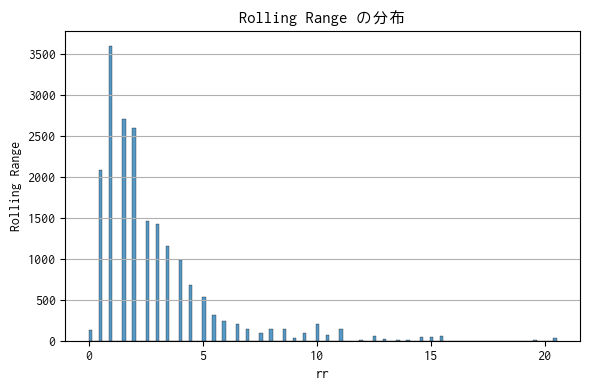

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("Rolling Range の分布")
sns.histplot(data=df_tech, x="rr", bins="sqrt")
# ax.axvline(x=THRESHOLD_SLOPE, color="red", linewidth=0.75, label="THRESHOLD_SLOPE")
# ax.set_yscale("log")
ax.set_ylabel("Rolling Range")
ax.grid(axis="y")
# ax.legend(fontsize=7)

plt.tight_layout()
output_dir = os.path.join("output", date_str)
os.makedirs(output_dir, exist_ok=True)
output = os.path.join(output_dir, f"{code}_hist_rr.png")
print(output)
plt.savefig(output)
plt.show()

In [12]:
# 観測値
print("観測値")
df_obs = app.getObservations()
print(df_obs)

観測値
                     クロスS1  クロスS2  クロ強  乱高下  ロス1  利確1   建玉
2026-01-16 09:00:04    0.0    0.0  0.0  0.0  0.0  0.0  0.0
2026-01-16 09:00:05    0.0    0.0  0.0  0.0  0.0  0.0  0.0
2026-01-16 09:00:06    0.0    0.0  0.0  0.0  0.0  0.0  0.0
2026-01-16 09:00:07    0.0    0.0  0.0  0.0  0.0  0.0  0.0
2026-01-16 09:00:08    0.0    0.0  0.0  0.0  0.0  0.0  0.0
...                    ...    ...  ...  ...  ...  ...  ...
2026-01-16 15:24:45    0.0    0.0  0.0  0.0  0.0  0.0  0.0
2026-01-16 15:24:46    0.0    0.0  0.0  0.0  0.0  0.0  0.0
2026-01-16 15:24:47    0.0    0.0  0.0  0.0  0.0  0.0  0.0
2026-01-16 15:24:48    0.0    0.0  0.0  0.0  0.0  0.0  0.0
2026-01-16 15:24:49    0.0    0.0  0.0  0.0  0.0  0.0  0.0

[19427 rows x 7 columns]


output/2026/01/16/8306_trend_obs.png


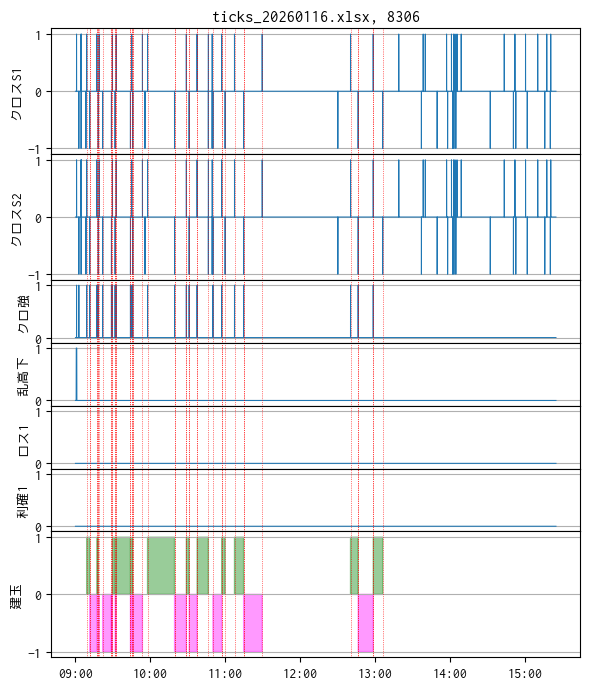

In [13]:
n = len(df_obs.columns)
fig = plt.figure(figsize=(6, n))
ax = dict()

targets = {"クロスS1", "クロスS2", "建玉"}
list_height_ratio = [2 if col in targets else 1 for col in df_obs.columns]
gs = fig.add_gridspec(n, 1, wspace=0.0, hspace=0.0, height_ratios=list_height_ratio)
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis
    ax[i].grid(axis="y")

ax[0].set_title(f"{excel}, {code}")

special_cross = {"クロスS1", "クロスS2"}

for i, colname in enumerate(df_obs.columns):
    ax_i = ax[i]

    if colname in special_cross:
        ax_i.plot(df_obs[colname], linewidth=0.75)
        ax_i.set_ylim(-1.1, 1.1)

    elif colname == "建玉":
        x = df_obs.index
        y = df_obs[colname]
        ax_i.fill_between(
            x, 0, y, where=y > 0, color="green", alpha=0.4, interpolate=True
        )
        ax_i.fill_between(
            x, 0, y, where=y < 0, color="magenta", alpha=0.4, interpolate=True
        )
        ax_i.set_ylim(-1.1, 1.1)

    else:
        ax_i.plot(df_obs[colname], linewidth=0.75)
        ax_i.set_ylim(-0.1, 1.1)

    ax_i.set_ylabel(colname)
    ax_i.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

for i in range(n):
    for t in list_trans:
        ax[i].axvline(x=t, color="red", linestyle="dotted", linewidth=0.5)

plt.tight_layout()
output_dir = os.path.join("output", date_str)
os.makedirs(output_dir, exist_ok=True)
output = os.path.join(output_dir, f"{code}_trend_obs.png")
print(output)
plt.tight_layout()
plt.savefig(output)
plt.show()